<a href="https://colab.research.google.com/github/Daniel-Francisco-Calderon-Lebro/Vision_por_Computador/blob/main/SegmentacionSemanticaDrive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sensioai/blog/blob/master/050_cv_segmentacion/cv_segmentacion.ipynb)

# Segmentación semántica


Consiste en clasificar cada píxel de la imagen para crear un `mapa de segmentación`, es decir, una imagen de igual resolución que la imagen utilizada a la entrada en la que cada pixel es sustituido por una etiqueta.

![](https://miro.medium.com/max/1575/1*kvh9u8W2sHlQoBPfwERggA.gif)



## Posibles arquitecturas

Una `CNN` que no reduzca las dimensiones de sujs resultados. Se busca un conjunto de filtros sin usar `pooling`. Como no se cabia de dimensió, no se extraen características a diferentes escalas.

![](https://theaisummer.com/assets/img/posts/Semantic_Segmentation/fcn1.jpg)



Una arquitectura `encoder-decoder`, en la que  una `CNN` extrae características a diferentes escalas y otra `CNN` recupera las dimensiones originales. En esta arquitectura surge la pregunta ¿cómo incrementar la dimensión de forma correcta?


![](https://codealogic.files.wordpress.com/2018/05/ml2.png?w=810)


Recuperar información en el `decoder` tomando solo la salida del `encoder` es un problema de alta complejidad.

La arquitectura `UNet` ofrece una solución elegante al problema. En esta estrategia, en cada etapa del `decoder` entra la salida de la capa anterior junto a la salida de la capa correspondiente del `encoder`.

![](https://miro.medium.com/v2/resize:fit:1400/1*VUS2cCaPB45wcHHFp_fQZQ.png)



# Problema: Segmentación de Imágenes de Resonancia Magnetica MRIs


Se dispone de un conjunto de imágenes de MRIs con sus correspondientes máscaras de segmentación.

El objetivo es segmentar una MRI cerebral para detectar la materia gris y blanca.

Esto es importante ya que conocer la cantidad de materia gris y blanca, así como su evolución en el tiempo es clave para la detección temprana y tratamiento de enfermedades.

- Se descarga el dataset

In [ ]:
!wget 'https://mymldatasets.s3.eu-de.cloud-object-storage.appdomain.cloud/MRIs.zip'

--2023-11-08 15:09:32--  https://mymldatasets.s3.eu-de.cloud-object-storage.appdomain.cloud/MRIs.zip
Resolving mymldatasets.s3.eu-de.cloud-object-storage.appdomain.cloud (mymldatasets.s3.eu-de.cloud-object-storage.appdomain.cloud)... 158.177.118.97
Connecting to mymldatasets.s3.eu-de.cloud-object-storage.appdomain.cloud (mymldatasets.s3.eu-de.cloud-object-storage.appdomain.cloud)|158.177.118.97|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 189839467 (181M) [application/zip]
Saving to: ‘MRIs.zip’

MRIs.zip            100%[===================>] 181.04M  18.4MB/s    in 12s     

2023-11-08 15:09:45 (15.5 MB/s) - ‘MRIs.zip’ saved [189839467/189839467]



- Se descomprime

In [ ]:
import zipfile
with zipfile.ZipFile('MRIs.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

- Observe que se tiene un folder con las MRIs y un folder con las segmentaciones.

In [ ]:
import os
from pathlib import Path

path = Path('./MRIs')
imgs = [path/'MRIs'/i for i in os.listdir(path/'MRIs')]
ixs = [i.split('_')[-1] for i in os.listdir(path/'MRIs')]
masks = [path/'Segmentations'/f'segm_{ix}' for ix in ixs]

print(len(imgs), ' imágenes y ',len(masks), ' máscaras.')
print('Una de las imágenes es ',imgs[0])
print('Una de las máscaras es ',masks[0])

425  imágenes y  425  máscaras.
Una de las imágenes es  MRIs/MRIs/img_128.npy
Una de las máscaras es  MRIs/Segmentations/segm_128.npy


- 425 imágenes almacenadas como `arrays` de `NumPy`.

- Se puede visualizar una muestra

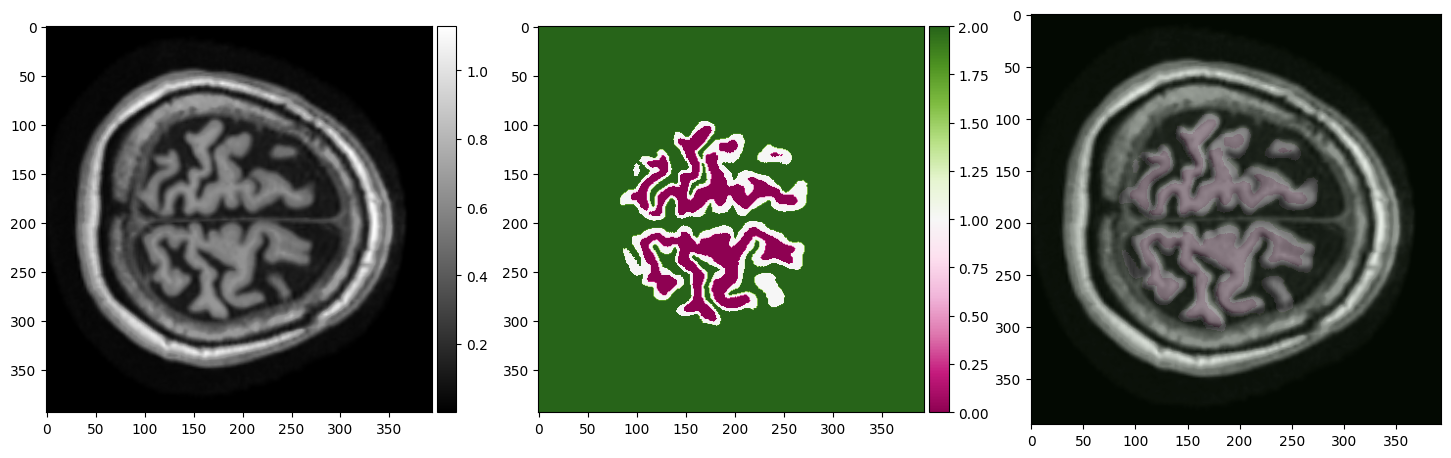

In [ ]:
from matplotlib.figure import cbar
from matplotlib.colors import Colormap
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

muestra = 100

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,6)) #espacio para 3 gráficas
img = np.load(imgs[muestra]) #
mask = np.load(masks[muestra])
g1 = ax1.imshow(img,cmap = 'gray')
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(g1, cax=cax, orientation='vertical');



g2 = ax2.imshow(mask,cmap = 'PiYG')
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(g2, cax=cax, orientation='vertical');

ax3.imshow(img,cmap = 'gray')
ax3.imshow(mask, alpha=0.1,cmap = 'PiYG')
plt.show()
print('imágenes de tamaño ', img.shape,' y tipo ',img.dtype)
print('mascaras de tamaño ', mask.shape,' y tipo ',mask.dtype)

Las máscaras tienen tipo es `unit8` codificadas como:

 - 0: materia blanca
 - 1: materia gris
 - 2: fondo

Para entrenar la red se requiere de máscaras `one-hot encoding`.

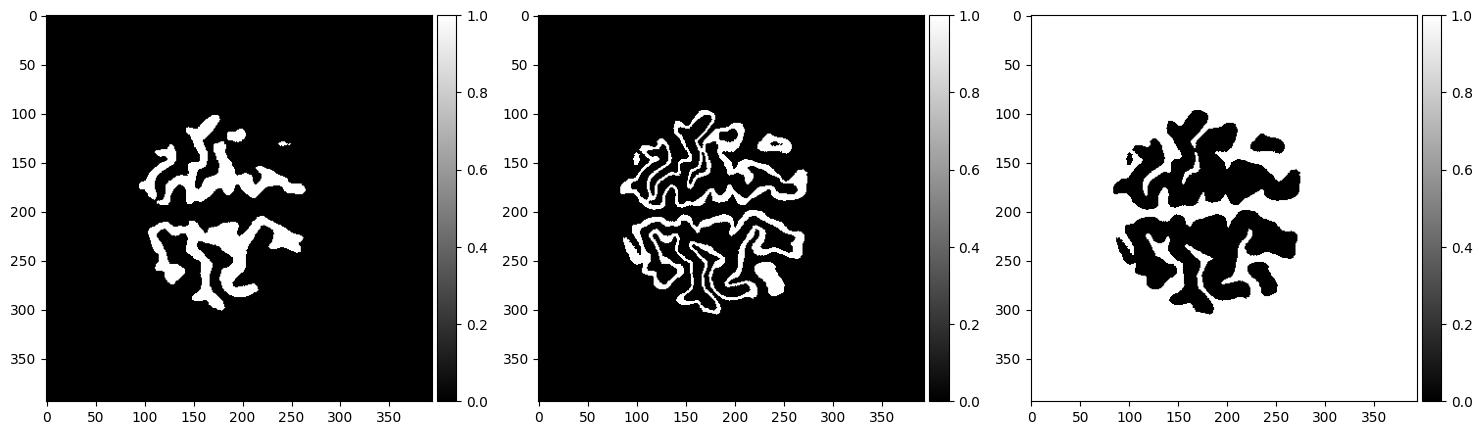

In [ ]:
# one-hot encoding
mask_oh = (np.arange(3) == mask[...,None]).astype(np.float32)

mask_oh.shape

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,6)) #espacio para 3 gráficas
g1 = ax1.imshow(mask_oh[:,:,0],cmap = 'gray')
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(g1, cax=cax, orientation='vertical');


g2 = ax2.imshow(mask_oh[:,:,1],cmap = 'gray')
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(g2, cax=cax, orientation='vertical');

g3 = ax3.imshow(mask_oh[:,:,2],cmap = 'gray')
divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(g3, cax=cax, orientation='vertical');


## UNet


![](https://miro.medium.com/v2/resize:fit:1400/1*VUS2cCaPB45wcHHFp_fQZQ.png)



In [ ]:
import torch
import torch.nn.functional as F

def conv3x3_bn(ci, co):
    return torch.nn.Sequential(
        torch.nn.Conv2d(ci, co, 3, padding=1),
        torch.nn.BatchNorm2d(co),
        torch.nn.ReLU(inplace=True)
    )

def encoder_conv(ci, co):
  return torch.nn.Sequential(
        torch.nn.MaxPool2d(2),
        conv3x3_bn(ci, co),
        conv3x3_bn(co, co),
    )

class deconv(torch.nn.Module):
    def __init__(self, ci, co):
        super(deconv, self).__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, 2, stride=2)
        self.conv1 = conv3x3_bn(ci, co)
        self.conv2 = conv3x3_bn(co, co)

    # recibe la salida de la capa anetrior y la salida de la etapa
    # correspondiente del encoder
    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        # concatenamos los tensores
        x = torch.cat([x2, x1], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

class UNet(torch.nn.Module):
    def __init__(self, n_classes=3, in_ch=1):
        super().__init__()

        # lista de capas en encoder-decoder con número de filtros
        c = [16, 32, 64, 128]

        # primera capa conv que recibe la imagen
        self.conv1 = torch.nn.Sequential(
          conv3x3_bn(in_ch, c[0]),
          conv3x3_bn(c[0], c[0]),
        )
        # capas del encoder
        self.conv2 = encoder_conv(c[0], c[1])
        self.conv3 = encoder_conv(c[1], c[2])
        self.conv4 = encoder_conv(c[2], c[3])

        # capas del decoder
        self.deconv1 = deconv(c[3],c[2])
        self.deconv2 = deconv(c[2],c[1])
        self.deconv3 = deconv(c[1],c[0])

        # útlima capa conv que nos da la máscara
        self.out = torch.nn.Conv2d(c[0], n_classes, 3, padding=1)

    def forward(self, x):
        # encoder
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        x = self.conv4(x3)
        # decoder
        x = self.deconv1(x, x3)
        x = self.deconv2(x, x2)
        x = self.deconv3(x, x1)
        x = self.out(x)
        return x

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = UNet()

model

UNet(
  (conv1): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (conv2): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

## Ajuste con 1 muestra



La métrica IoU es apropiada para evaluar coincidencias en áreas.

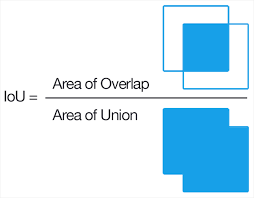

In [ ]:
def fit(model, X, y, epochs=1, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    model.to(device)
    X, y = X.to(device), y.to(device)
    model.train()
    for epoch in range(1, epochs+1):
        optimizer.zero_grad()
        y_hat = model(X)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        ious = iou(y_hat, y)
        print(f"Epoch {epoch}/{epochs} loss {loss.item():.5f} iou {ious:.5f}")

def iou(outputs, labels):
    # aplicar sigmoid y convertir a binario
    outputs, labels = torch.sigmoid(outputs) > 0.5, labels > 0.5
    SMOOTH = 1e-6
    # BATCH x num_classes x H x W
    B, N, H, W = outputs.shape
    ious = []
    for i in range(N-1): # saltamos el background
        _out, _labs = outputs[:,i,:,:], labels[:,i,:,:]
        intersection = (_out & _labs).float().sum((1, 2))
        union = (_out | _labs).float().sum((1, 2))
        iou = (intersection + SMOOTH) / (union + SMOOTH)
        ious.append(iou.mean().item())
    return np.mean(ious)

In [ ]:

img_tensor = torch.tensor(img).unsqueeze(0).unsqueeze(0)# lleva la imagen a formato apropiado de la red
mask_tensor = torch.tensor(mask_oh).permute(2, 0, 1).unsqueeze(0)# lleva la mascara a formato apropiado de la red

fit(model, img_tensor, mask_tensor, epochs=100)

Epoch 1/100 loss 0.75260 iou 0.06345
Epoch 2/100 loss 0.70397 iou 0.08991
Epoch 3/100 loss 0.66409 iou 0.11034
Epoch 4/100 loss 0.62941 iou 0.12550
Epoch 5/100 loss 0.59640 iou 0.15497
Epoch 6/100 loss 0.56675 iou 0.21989
Epoch 7/100 loss 0.53907 iou 0.27933
Epoch 8/100 loss 0.51264 iou 0.32905
Epoch 9/100 loss 0.48655 iou 0.40773
Epoch 10/100 loss 0.46291 iou 0.44753
Epoch 11/100 loss 0.44086 iou 0.46632
Epoch 12/100 loss 0.42091 iou 0.46974
Epoch 13/100 loss 0.40229 iou 0.47674
Epoch 14/100 loss 0.38315 iou 0.47412
Epoch 15/100 loss 0.36626 iou 0.47531
Epoch 16/100 loss 0.34915 iou 0.47272
Epoch 17/100 loss 0.33316 iou 0.47073
Epoch 18/100 loss 0.31794 iou 0.48343
Epoch 19/100 loss 0.30362 iou 0.45816
Epoch 20/100 loss 0.29016 iou 0.42080
Epoch 21/100 loss 0.27756 iou 0.39436
Epoch 22/100 loss 0.26574 iou 0.37992
Epoch 23/100 loss 0.25441 iou 0.37786
Epoch 24/100 loss 0.24388 iou 0.37373
Epoch 25/100 loss 0.23398 iou 0.37061
Epoch 26/100 loss 0.22461 iou 0.37541
Epoch 27/100 loss 0.2

Pueden generarse predicciones.



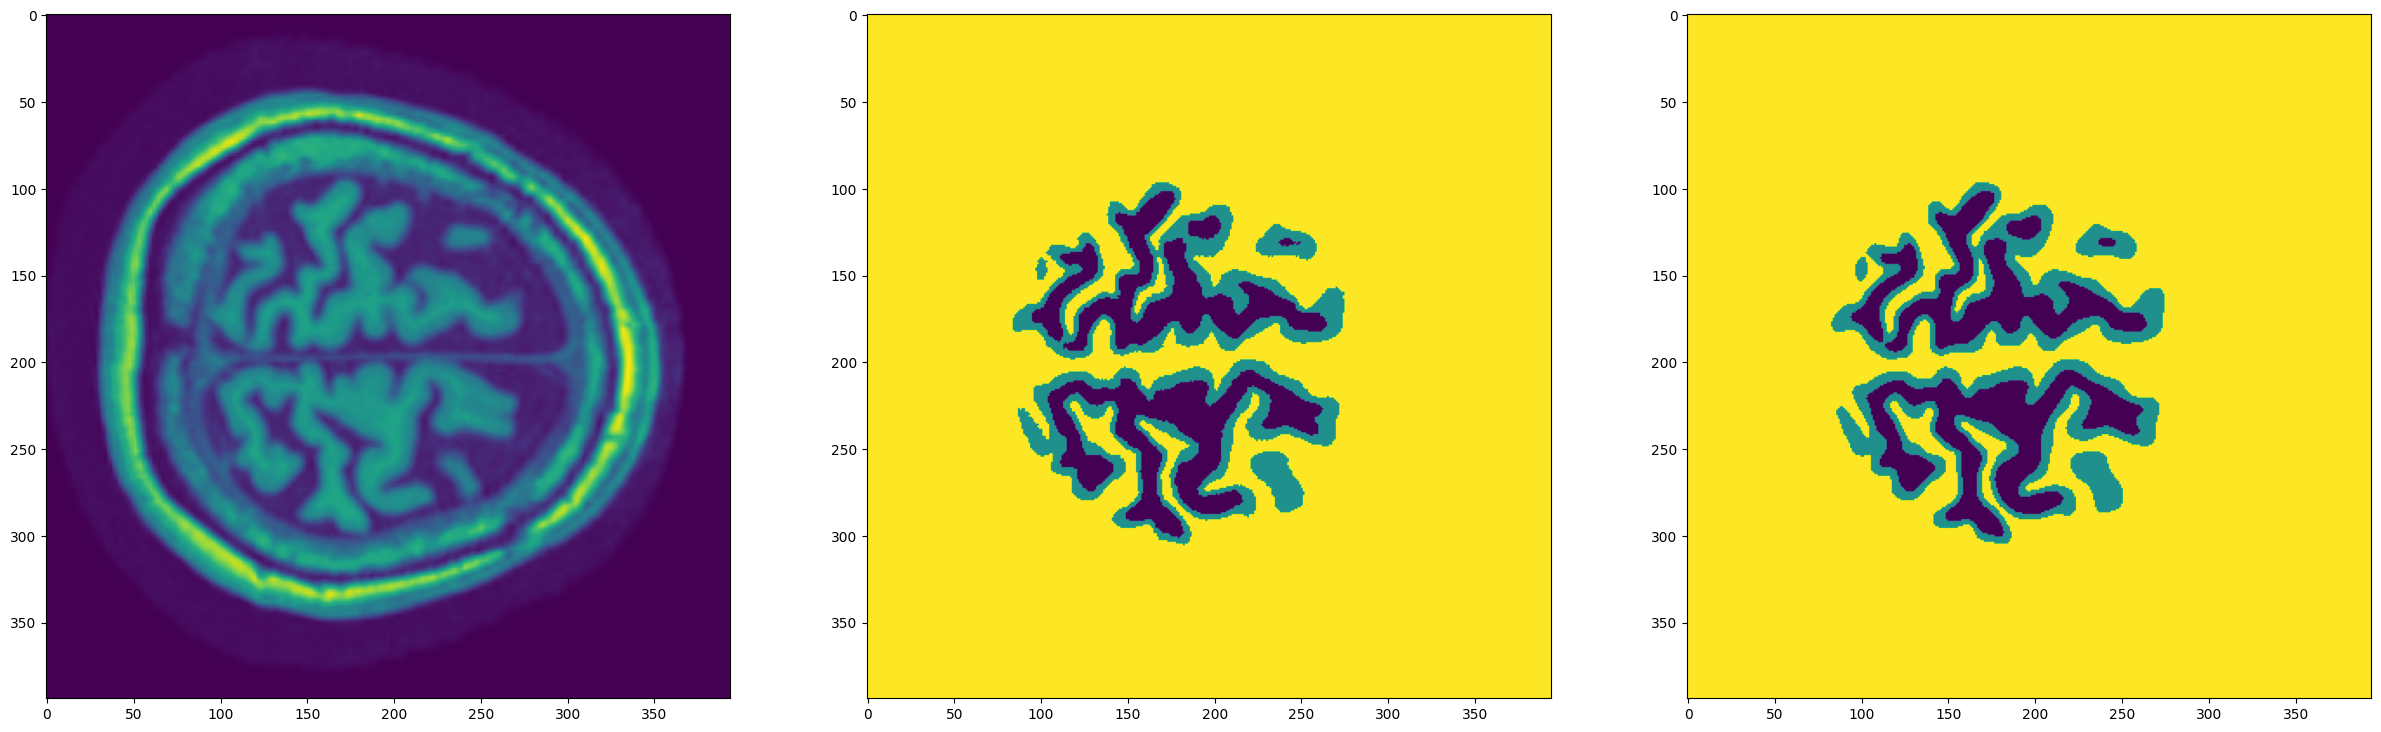

In [ ]:

model.eval()
with torch.no_grad():
    output = model(img_tensor.to(device))[0]
    pred_mask = torch.argmax(output, axis=0)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
ax1.imshow(img)
ax2.imshow(mask)
ax3.imshow(pred_mask.squeeze().cpu().numpy())
plt.show()

## Ajuste con todo el dataset



In [ ]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y, n_classes=3):
    self.X = X
    self.y = y
    self.n_classes = n_classes

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    img = np.load(self.X[ix])
    mask = np.load(self.y[ix])
    img = torch.tensor(img).unsqueeze(0)
    mask = (np.arange(self.n_classes) == mask[...,None]).astype(np.float32)
    return img, torch.from_numpy(mask).permute(2,0,1)

In [ ]:
dataset = {
    'train': Dataset(imgs[:-100], masks[:-100]),
    'test': Dataset(imgs[-100:], masks[-100:])
}

len(dataset['train']), len(dataset['test'])

(325, 100)

In [ ]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=16, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=32, pin_memory=True)
}

imgs, masks = next(iter(dataloader['train']))
imgs.shape, masks.shape

(torch.Size([16, 1, 394, 394]), torch.Size([16, 3, 394, 394]))

In [ ]:
from tqdm import tqdm

def fit(model, dataloader, epochs=100, lr=3e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    model.to(device)
    hist = {'loss': [], 'iou': [], 'test_loss': [], 'test_iou': []}
    for epoch in range(1, epochs+1):
      bar = tqdm(dataloader['train'])
      train_loss, train_iou = [], []
      model.train()
      for imgs, masks in bar:
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        y_hat = model(imgs)
        loss = criterion(y_hat, masks)
        loss.backward()
        optimizer.step()
        ious = iou(y_hat, masks)
        train_loss.append(loss.item())
        train_iou.append(ious)
        bar.set_description(f"loss {np.mean(train_loss):.5f} iou {np.mean(train_iou):.5f}")
      hist['loss'].append(np.mean(train_loss))
      hist['iou'].append(np.mean(train_iou))
      bar = tqdm(dataloader['test'])
      test_loss, test_iou = [], []
      model.eval()
      with torch.no_grad():
        for imgs, masks in bar:
          imgs, masks = imgs.to(device), masks.to(device)
          y_hat = model(imgs)
          loss = criterion(y_hat, masks)
          ious = iou(y_hat, masks)
          test_loss.append(loss.item())
          test_iou.append(ious)
          bar.set_description(f"test_loss {np.mean(test_loss):.5f} test_iou {np.mean(test_iou):.5f}")
      hist['test_loss'].append(np.mean(test_loss))
      hist['test_iou'].append(np.mean(test_iou))
      print(f"\nEpoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} iou {np.mean(train_iou):.5f} test_loss {np.mean(test_loss):.5f} test_iou {np.mean(test_iou):.5f}")
    return hist

In [ ]:
model = UNet()
hist = fit(model, dataloader, epochs=30)

test_loss 0.65711 test_iou 0.12891: 100%|██████████| 4/4 [00:01<00:00,  2.95it/s]



Epoch 1/30 loss 0.65917 iou 0.19622 test_loss 0.65711 test_iou 0.12891


test_loss 0.50656 test_iou 0.28888: 100%|██████████| 4/4 [00:01<00:00,  3.14it/s]



Epoch 2/30 loss 0.52245 iou 0.37714 test_loss 0.50656 test_iou 0.28888


test_loss 0.36497 test_iou 0.63097: 100%|██████████| 4/4 [00:01<00:00,  2.48it/s]



Epoch 3/30 loss 0.41822 iou 0.56741 test_loss 0.36497 test_iou 0.63097


test_loss 0.30199 test_iou 0.61267: 100%|██████████| 4/4 [00:01<00:00,  3.16it/s]



Epoch 4/30 loss 0.32787 iou 0.64241 test_loss 0.30199 test_iou 0.61267


test_loss 0.24298 test_iou 0.69109: 100%|██████████| 4/4 [00:01<00:00,  3.10it/s]



Epoch 5/30 loss 0.26186 iou 0.67397 test_loss 0.24298 test_iou 0.69109


test_loss 0.20417 test_iou 0.68384: 100%|██████████| 4/4 [00:01<00:00,  3.11it/s]



Epoch 6/30 loss 0.21790 iou 0.68605 test_loss 0.20417 test_iou 0.68384


test_loss 0.17634 test_iou 0.70146: 100%|██████████| 4/4 [00:01<00:00,  3.11it/s]



Epoch 7/30 loss 0.18670 iou 0.69648 test_loss 0.17634 test_iou 0.70146


test_loss 0.16123 test_iou 0.71384: 100%|██████████| 4/4 [00:01<00:00,  3.12it/s]



Epoch 8/30 loss 0.16193 iou 0.71221 test_loss 0.16123 test_iou 0.71384


test_loss 0.14931 test_iou 0.70996: 100%|██████████| 4/4 [00:01<00:00,  2.48it/s]



Epoch 9/30 loss 0.14421 iou 0.71834 test_loss 0.14931 test_iou 0.70996


test_loss 0.18876 test_iou 0.49759: 100%|██████████| 4/4 [00:01<00:00,  3.10it/s]



Epoch 10/30 loss 0.13106 iou 0.72313 test_loss 0.18876 test_iou 0.49759


test_loss 0.12511 test_iou 0.71764: 100%|██████████| 4/4 [00:01<00:00,  3.10it/s]



Epoch 11/30 loss 0.12111 iou 0.72464 test_loss 0.12511 test_iou 0.71764


test_loss 0.11115 test_iou 0.73195: 100%|██████████| 4/4 [00:01<00:00,  3.14it/s]



Epoch 12/30 loss 0.11061 iou 0.73531 test_loss 0.11115 test_iou 0.73195


test_loss 0.10523 test_iou 0.73209: 100%|██████████| 4/4 [00:01<00:00,  3.15it/s]



Epoch 13/30 loss 0.10305 iou 0.74135 test_loss 0.10523 test_iou 0.73209


test_loss 0.09955 test_iou 0.72452: 100%|██████████| 4/4 [00:01<00:00,  3.09it/s]



Epoch 14/30 loss 0.09692 iou 0.74491 test_loss 0.09955 test_iou 0.72452


test_loss 0.09073 test_iou 0.74734: 100%|██████████| 4/4 [00:01<00:00,  2.57it/s]



Epoch 15/30 loss 0.09230 iou 0.74812 test_loss 0.09073 test_iou 0.74734


test_loss 0.08938 test_iou 0.73170: 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]



Epoch 16/30 loss 0.08737 iou 0.75361 test_loss 0.08938 test_iou 0.73170


test_loss 0.08650 test_iou 0.74060: 100%|██████████| 4/4 [00:01<00:00,  3.10it/s]



Epoch 17/30 loss 0.08396 iou 0.75681 test_loss 0.08650 test_iou 0.74060


test_loss 0.08333 test_iou 0.74841: 100%|██████████| 4/4 [00:01<00:00,  3.09it/s]



Epoch 18/30 loss 0.08082 iou 0.75821 test_loss 0.08333 test_iou 0.74841


test_loss 0.07764 test_iou 0.75283: 100%|██████████| 4/4 [00:01<00:00,  3.11it/s]



Epoch 19/30 loss 0.07772 iou 0.76137 test_loss 0.07764 test_iou 0.75283


test_loss 0.08150 test_iou 0.73910: 100%|██████████| 4/4 [00:01<00:00,  3.11it/s]



Epoch 20/30 loss 0.07430 iou 0.76776 test_loss 0.08150 test_iou 0.73910


test_loss 0.07475 test_iou 0.75112: 100%|██████████| 4/4 [00:01<00:00,  3.03it/s]



Epoch 21/30 loss 0.07128 iou 0.77342 test_loss 0.07475 test_iou 0.75112


test_loss 0.07260 test_iou 0.76145: 100%|██████████| 4/4 [00:01<00:00,  2.47it/s]



Epoch 22/30 loss 0.06866 iou 0.77793 test_loss 0.07260 test_iou 0.76145


test_loss 0.07234 test_iou 0.76605: 100%|██████████| 4/4 [00:01<00:00,  3.10it/s]



Epoch 23/30 loss 0.06679 iou 0.78041 test_loss 0.07234 test_iou 0.76605


test_loss 0.07106 test_iou 0.75491: 100%|██████████| 4/4 [00:01<00:00,  3.08it/s]



Epoch 24/30 loss 0.06474 iou 0.78416 test_loss 0.07106 test_iou 0.75491


test_loss 0.06898 test_iou 0.76787: 100%|██████████| 4/4 [00:01<00:00,  3.13it/s]



Epoch 25/30 loss 0.06378 iou 0.78401 test_loss 0.06898 test_iou 0.76787


test_loss 0.06666 test_iou 0.75670: 100%|██████████| 4/4 [00:01<00:00,  3.11it/s]



Epoch 26/30 loss 0.06260 iou 0.78444 test_loss 0.06666 test_iou 0.75670


test_loss 0.07119 test_iou 0.76325: 100%|██████████| 4/4 [00:01<00:00,  3.10it/s]



Epoch 27/30 loss 0.06007 iou 0.79147 test_loss 0.07119 test_iou 0.76325


test_loss 0.06474 test_iou 0.77067: 100%|██████████| 4/4 [00:01<00:00,  2.70it/s]



Epoch 28/30 loss 0.05817 iou 0.79621 test_loss 0.06474 test_iou 0.77067


test_loss 0.06342 test_iou 0.76975: 100%|██████████| 4/4 [00:01<00:00,  2.55it/s]



Epoch 29/30 loss 0.05704 iou 0.79814 test_loss 0.06342 test_iou 0.76975


test_loss 0.06489 test_iou 0.77276: 100%|██████████| 4/4 [00:01<00:00,  3.11it/s]


Epoch 30/30 loss 0.05677 iou 0.79746 test_loss 0.06489 test_iou 0.77276


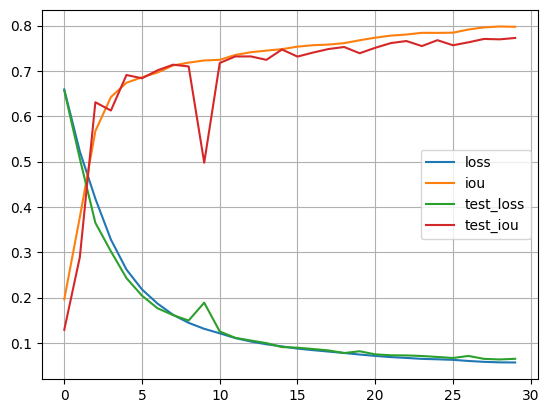

In [ ]:
import pandas as pd
df = pd.DataFrame(hist)
df.plot(grid=True)
plt.show()

- Prueba con imágenes aleatorias.

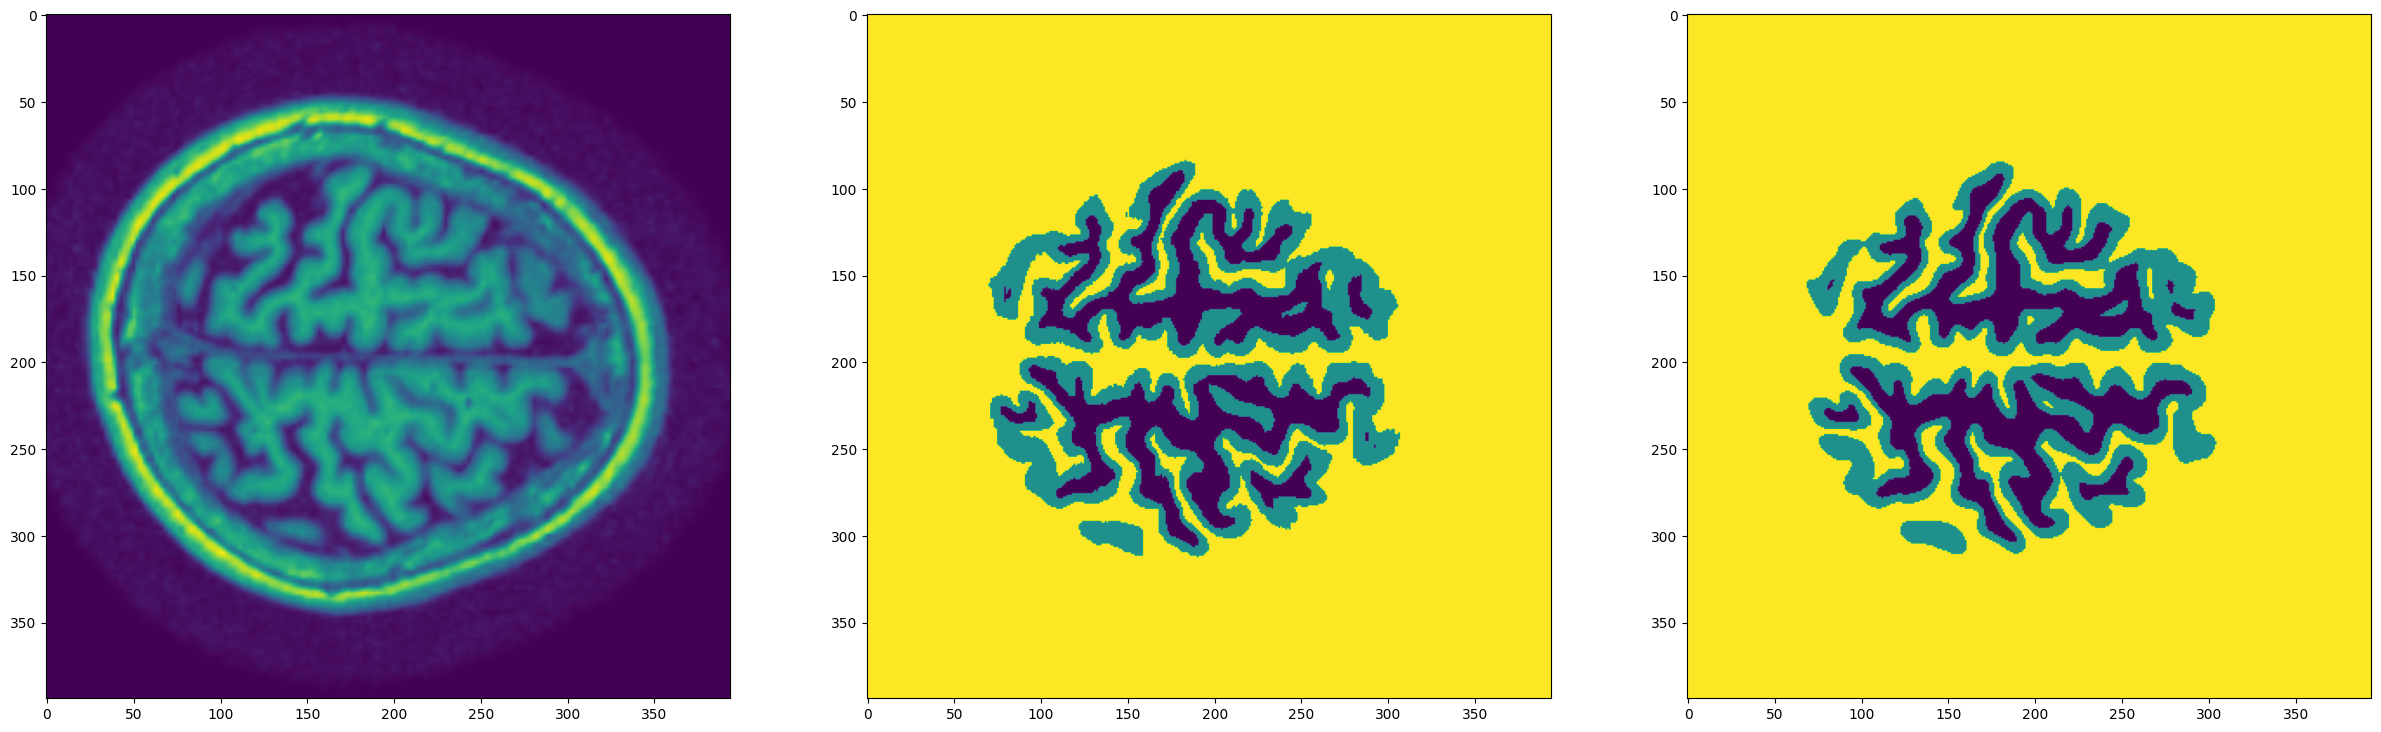

In [ ]:
import random

model.eval()
with torch.no_grad():
    ix = random.randint(0, len(dataset['test'])-1)
    img, mask = dataset['test'][ix]
    output = model(img.unsqueeze(0).to(device))[0]
    pred_mask = torch.argmax(output, axis=0)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
ax1.imshow(img.squeeze(0))
ax2.imshow(torch.argmax(mask, axis=0))
ax3.imshow(pred_mask.squeeze().cpu().numpy())
plt.show()